#  Winpython Default checker

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
# warnings.filterwarnings("ignore")  # would silence all warnings

In [ ]:
%matplotlib inline

## Compilers: Numba and Cython

##### Requirement
To get Cython working, Winpython 3.5 users should install "Microsoft Visual C++ Build Tools 2015" (visualcppbuildtools_full.exe, a 4 Go installation) at https://beta.visualstudio.com/download-visual-studio-vs/

To get Numba working, not-windows10 users may have to install "Microsoft Visual C++ 2015 Redistributable" (vc_redist) at  <https://beta.visualstudio.com/download-visual-studio-vs/>

#### Compiler toolchains

In [ ]:
# checking Numba JIT toolchain
import numpy as np
image = np.zeros((1024, 1536), dtype = np.uint8)

from pylab import imshow, show
from timeit import default_timer as timer

def create_fractal(min_x, max_x, min_y, max_y, image, iters , mandelx):
  height = image.shape[0]
  width = image.shape[1]
  pixel_size_x = (max_x - min_x) / width
  pixel_size_y = (max_y - min_y) / height
    
  for x in range(width):
    real = min_x + x * pixel_size_x
    for y in range(height):
      imag = min_y + y * pixel_size_y
      color = mandelx(real, imag, iters)
      image[y, x] = color

##### Numba (a JIT Compiler)

In [ ]:
from numba import autojit

@autojit
def mandel(x, y, max_iters):
  c = complex(x, y)
  z = 0.0j
  for i in range(max_iters):
    z = z*z + c
    if (z.real*z.real + z.imag*z.imag) >= 4:
      return i
  return max_iters

start = timer()
create_fractal(-2.0, 1.0, -1.0, 1.0, image, 20 , mandel) 
dt = timer() - start

print ("Mandelbrot created by numba in %f s" % dt)
imshow(image)
show()

##### Cython (a compiler for writing C extensions for the Python language)
WinPython 3.5 and 3.6 users may not have mingwpy available, and so need "VisualStudio C++ Community Edition 2015" https://www.visualstudio.com/downloads/download-visual-studio-vs#d-visual-c  

In [ ]:
# Cython + Mingwpy compiler toolchain test
%load_ext Cython

In [ ]:
%%cython -a
# with %%cython -a , full C-speed lines are shown in white, slowest python-speed lines are shown in dark yellow lines 
# ==> put your cython rewrite effort on dark yellow lines
def mandel_cython(x, y, max_iters):
  cdef int   i 
  cdef double   cx, cy , zx, zy
  cx , cy = x, y 
  zx , zy =0 ,0 
  for i in range(max_iters):
    zx , zy = zx*zx - zy*zy + cx , zx*zy*2 + cy
    if (zx*zx + zy*zy) >= 4:
      return i
  return max_iters

In [ ]:
start = timer()
create_fractal(-2.0, 1.0, -1.0, 1.0, image, 20 , mandel_cython) 
dt = timer() - start

print ("Mandelbrot created by cython in %f s" % dt)
imshow(image)

##  Graphics: Matplotlib, Pandas, Seaborn, Holoviews, Bokeh, bqplot, ipyleaflet, plotnine

In [ ]:
# Matplotlib
# for more examples, see: http://matplotlib.org/gallery.html
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm

fig = plt.figure()
ax = fig.gca(projection='3d')
X, Y, Z = axes3d.get_test_data(0.05)
ax.plot_surface(X, Y, Z, rstride=8, cstride=8, alpha=0.3)
cset = ax.contourf(X, Y, Z, zdir='z', offset=-100, cmap=cm.coolwarm)
cset = ax.contourf(X, Y, Z, zdir='x', offset=-40, cmap=cm.coolwarm)
cset = ax.contourf(X, Y, Z, zdir='y', offset=40, cmap=cm.coolwarm)

ax.set_xlabel('X')
ax.set_xlim(-40, 40)
ax.set_ylabel('Y')
ax.set_ylim(-40, 40)
ax.set_zlabel('Z')
ax.set_zlim(-100, 100)

plt.show()

In [ ]:
# Seaborn
# for more examples, see http://stanford.edu/~mwaskom/software/seaborn/examples/index.html
import seaborn as sns
sns.set()
df = sns.load_dataset("iris")
sns.pairplot(df, hue="species", size=1.5)

In [ ]:
# altair 1.3 example
import altair as at
at.Chart(df).mark_bar().encode(
    x=at.X('sepal_length', bin=at.Bin(maxbins=50)),
    y='count(*):Q',
    color='species:N',
    # column='species',
).configure_cell(width=200)

In [ ]:
# Holoviews
# for more example, see http://holoviews.org/Tutorials/index.html
import numpy as np
import holoviews as hv
hv.extension('matplotlib')
dots = np.linspace(-0.45, 0.45, 11)
fractal = hv.Image(image)

layouts = {y: (fractal * hv.Points(fractal.sample([(i,y) for i in dots])) +
               fractal.sample(y=y) )
            for y in np.linspace(0, 0.45,11)}

hv.HoloMap(layouts, kdims=['Y']).collate().cols(2)

In [ ]:
# Bokeh 0.12.5 
import numpy as np
from six.moves import zip
from bokeh.plotting import figure, show, output_notebook
N = 4000
x = np.random.random(size=N) * 100
y = np.random.random(size=N) * 100
radii = np.random.random(size=N) * 1.5
colors = ["#%02x%02x%02x" % (int(r), int(g), 150) for r, g in zip(50+2*x, 30+2*y)]

output_notebook()
TOOLS="hover,crosshair,pan,wheel_zoom,box_zoom,reset,tap,save,box_select,poly_select,lasso_select"

p = figure(tools=TOOLS)
p.scatter(x,y, radius=radii, fill_color=colors, fill_alpha=0.6, line_color=None)
show(p)

In [ ]:
# Datashader (holoviews+Bokeh)
import numpy as np
import pandas as pd
import holoviews as hv
import datashader as ds
from holoviews.operation.datashader import aggregate, shade, datashade, dynspread
from bokeh.models import DatetimeTickFormatter
hv.extension('bokeh')

def time_series(T = 1, N = 100, mu = 0.1, sigma = 0.1, S0 = 20):  
    """Parameterized noisy time series"""
    dt = float(T)/N
    t = np.linspace(0, T, N)
    W = np.random.standard_normal(size = N) 
    W = np.cumsum(W)*np.sqrt(dt) # standard brownian motion
    X = (mu-0.5*sigma**2)*t + sigma*W 
    S = S0*np.exp(X) # geometric brownian motion
    return S

def apply_formatter(plot, element):
    plot.handles['xaxis'].formatter = DatetimeTickFormatter()
    
drange = pd.date_range(start="2014-01-01", end="2016-01-01", freq='1D') # or '1min'
dates = drange.values.astype('int64')/10**6 # Convert dates to ints
curve = hv.Curve((dates, time_series(N=len(dates), sigma = 1)))

In [ ]:
%%opts RGB [finalize_hooks=[apply_formatter] width=800]
%%opts Overlay [finalize_hooks=[apply_formatter] width=800] 
%%opts Scatter [tools=['hover', 'box_select']] (line_color="black" fill_color="red" size=10)

from holoviews.operation.timeseries import rolling, rolling_outlier_std
smoothed = rolling(curve, rolling_window=50)
outliers = rolling_outlier_std(curve, rolling_window=50, sigma=2)
datashade(curve, cmap=["blue"]) * dynspread(datashade(smoothed, cmap=["red"]),max_px=1) * outliers

In [ ]:
#bqplot
from IPython.display import display
from bqplot import (Figure, Map, Mercator, Orthographic, ColorScale, ColorAxis,
                    AlbersUSA, topo_load, Tooltip)
def_tt = Tooltip(fields=['id', 'name'])
map_mark = Map(scales={'projection': Mercator()}, tooltip=def_tt)
map_mark.interactions = {'click': 'select', 'hover': 'tooltip'}
fig = Figure(marks=[map_mark], title='Interactions Example')
display(fig)

In [ ]:
# ipyleaflet (javascript library usage)
from ipyleaflet import (
    Map, Marker, TileLayer, ImageOverlay, Polyline, Polygon,
    Rectangle, Circle, CircleMarker, GeoJSON, DrawControl
)
from traitlets import link
center = [34.6252978589571, -77.34580993652344]
m = Map(center=[34.6252978589571, -77.34580993652344], zoom=10)
dc = DrawControl()

def handle_draw(self, action, geo_json):
    print(action)
    print(geo_json)
m
m

In [ ]:
dc.on_draw(handle_draw)
m.add_control(dc)

In [ ]:
# plotnine: giving a taste of ggplot of R langage (formerly we were using ggpy)
from plotnine import ggplot, aes, geom_blank, geom_point, stat_smooth, facet_wrap, theme_bw
from plotnine.data import mtcars
ggplot(mtcars, aes(x='hp', y='wt', color='mpg')) + geom_point() +\
facet_wrap("~cyl") + theme_bw()

## Ipython Notebook: Interactivity & other

In [ ]:
import IPython;IPython.__version__

In [ ]:
# Audio Example : https://github.com/ipython/ipywidgets/blob/master/examples/Beat%20Frequencies.ipynb
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interactive
from IPython.display import Audio, display
def beat_freq(f1=220.0, f2=224.0):
    max_time = 3
    rate = 8000
    times = np.linspace(0,max_time,rate*max_time)
    signal = np.sin(2*np.pi*f1*times) + np.sin(2*np.pi*f2*times)
    print(f1, f2, abs(f1-f2))
    display(Audio(data=signal, rate=rate))
    return signal
v = interactive(beat_freq, f1=(200.0,300.0), f2=(200.0,300.0))
display(v)

In [ ]:
# Networks graph Example : https://github.com/ipython/ipywidgets/blob/master/examples/Exploring%20Graphs.ipynb
%matplotlib inline
from ipywidgets import interact
import matplotlib.pyplot as plt
import networkx as nx
# wrap a few graph generation functions so they have the same signature

def random_lobster(n, m, k, p):
    return nx.random_lobster(n, p, p / m)

def powerlaw_cluster(n, m, k, p):
    return nx.powerlaw_cluster_graph(n, m, p)

def erdos_renyi(n, m, k, p):
    return nx.erdos_renyi_graph(n, p)

def newman_watts_strogatz(n, m, k, p):
    return nx.newman_watts_strogatz_graph(n, k, p)

@interact(n=(2,30), m=(1,10), k=(1,10), p=(0.0, 1.0, 0.001),
        generator={'lobster': random_lobster,
                   'power law': powerlaw_cluster,
                   'Newman-Watts-Strogatz': newman_watts_strogatz,
                   u'Erdős-Rényi': erdos_renyi,
                   })
def plot_random_graph(n, m, k, p, generator):
    g = generator(n, m, k, p)
    nx.draw(g)
    plt.title(generator.__name__)
    plt.show()
    

In [ ]:
# checking nbconvert 
!jupyter nbconvert "Beginner's FAQ.ipynb" --to html

In [ ]:
%%HTML
<iframe src="Beginner's FAQ.html" width=700 height350></iframe>

## Mathematical: statsmodels, lmfit, 

In [ ]:
# checking statsmodels
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import statsmodels.api as sm
data = sm.datasets.anes96.load_pandas()
party_ID = np.arange(7)
labels = ["Strong Democrat", "Weak Democrat", "Independent-Democrat",
          "Independent-Independent", "Independent-Republican",
          "Weak Republican", "Strong Republican"]
plt.rcParams['figure.subplot.bottom'] = 0.23  # keep labels visible
plt.rcParams['figure.figsize'] = (6.0, 4.0)  # make plot larger in notebook
age = [data.exog['age'][data.endog == id] for id in party_ID]
fig = plt.figure()
ax = fig.add_subplot(111)
plot_opts={'cutoff_val':5, 'cutoff_type':'abs',
                                'label_fontsize':'small',
                                'label_rotation':30}
sm.graphics.beanplot(age, ax=ax, labels=labels,
                     plot_opts=plot_opts)
ax.set_xlabel("Party identification of respondent")
ax.set_ylabel("Age")

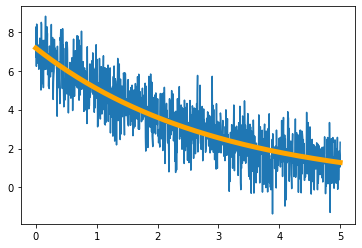

In [4]:
# lmfit test (from http://nbviewer.ipython.org/github/lmfit/lmfit-py/blob/master/examples/lmfit-model.ipynb)
import numpy as np
import matplotlib.pyplot as plt
def decay(t, N, tau):
    return N*np.exp(-t/tau)
t = np.linspace(0, 5, num=1000)
data = decay(t, 7, 3) + np.random.randn(*t.shape)

from lmfit import Model

model = Model(decay, independent_vars=['t'])
result = model.fit(data, t=t, N=10, tau=1)
plt.plot(t, data)  # data
plt.plot(t, decay(t=t, **result.values), color='orange', linewidth=5)  # best-fit model

## DataFrames: Pandas, Dask

In [1]:
#Pandas 
import pandas as pd
import numpy as np

idx = pd.date_range('2000', '2005', freq='d', closed='left')
datas = pd.DataFrame({'Color':  [ 'green' if x> 1 else 'red' for x in np.random.randn(len(idx))], 
         'Measure': np.random.randn(len(idx)), 'Year': idx.year},
          index=idx.date)
datas.head()

,Color,Measure,Year
2000-01-01,red,-0.399293,2000
2000-01-02,red,0.175402,2000
2000-01-03,green,2.033335,2000
2000-01-04,red,-0.389968,2000
2000-01-05,red,0.226198,2000


### Split / Apply / Combine    
    Split your data into multiple independent groups.
    Apply some function to each group.
    Combine your groups back into a single data object.


In [2]:
datas.query('Measure > 0').groupby(['Color','Year']).size().unstack()

Year,2000,2001,2002,2003,2004
Color,,,,,
green,30,28,36,28,25
red,151,162,153,151,164


## Web Scraping: Beautifulsoup

In [5]:
# checking Web Scraping: beautifulsoup and requests 
import requests
from bs4 import BeautifulSoup

URL = 'http://en.wikipedia.org/wiki/Franklin,_Tennessee'

req = requests.get(URL, headers={'User-Agent' : "Mining the Social Web"})
soup = BeautifulSoup(req.text, "lxml")

geoTag = soup.find(True, 'geo')

if geoTag and len(geoTag) > 1:
    lat = geoTag.find(True, 'latitude').string
    lon = geoTag.find(True, 'longitude').string
    print ('Location is at', lat, lon)
elif geoTag and len(geoTag) == 1:
    (lat, lon) = geoTag.string.split(';')
    (lat, lon) = (lat.strip(), lon.strip())
    print ('Location is at', lat, lon)
else:
    print ('No location found')

Location is at 35.92917 -86.85750


## Operations Research: Pulp

In [ ]:
# Pulp example : minimizing the weight to carry 99 pennies
#                (from Philip I Thomas)
# see https://www.youtube.com/watch?v=UmMn-N5w-lI#t=995
# Import PuLP modeler functions
from pulp import *
# The prob variable is created to contain the problem data        
prob = LpProblem("99 pennies Problem",LpMinimize)

# Variables represent how many of each coin we want to carry
pennies = LpVariable("Number of pennies",0,None,LpInteger)
nickels = LpVariable("Number of nickels",0,None,LpInteger)
dimes = LpVariable("Number of dimes",0,None,LpInteger)
quarters = LpVariable("Number of quarters",0,None,LpInteger)

# The objective function is added to 'prob' first

# we want to minimize (LpMinimize) this 
prob += 2.5 * pennies + 5 * nickels + 2.268 * dimes + 5.670 * quarters, "Total coins Weight"

# We want exactly 99 cents
prob += 1 * pennies + 5 * nickels + 10 * dimes + 25 * quarters == 99, ""

# The problem data is written to an .lp file
prob.writeLP("99cents.lp")
prob.solve()

# print ("status",LpStatus[prob.status] )
print ("Minimal Weight to carry exactly 99 pennies is %s grams" % value(prob.objective))
# Each of the variables is printed with it's resolved optimum value
for v in prob.variables():
    print (v.name, "=", v.varValue)

## Deep Learning: Theano

In [ ]:
# Checking Theano
import theano.tensor as T
from theano import function
x = T.dmatrix('x')
y = T.dmatrix('y')
z = x + y
f = function([x, y], z)
f([[1, 2], [3, 4]], [[10, 20], [30, 40]])

## Symbolic Calculation: sympy

In [6]:
# checking sympy 
import sympy
a, b =sympy.symbols('a b')
e=(a+b)**5
e.expand()

a**5 + 5*a**4*b + 10*a**3*b**2 + 10*a**2*b**3 + 5*a*b**4 + b**5

## SQL tools: sqlite, Ipython-sql, sqlite_bro, baresql, db.py

In [ ]:
# checking Ipython-sql, sqlparse, SQLalchemy
%load_ext sql

In [ ]:
%%sql sqlite:///.baresql.db
DROP TABLE IF EXISTS writer;
CREATE TABLE writer (first_name, last_name, year_of_death);
INSERT INTO writer VALUES ('William', 'Shakespeare', 1616);
INSERT INTO writer VALUES ('Bertold', 'Brecht', 1956);
SELECT  * , sqlite_version() as sqlite_version from Writer order by Year_of_death

In [ ]:
# checking baresql
from __future__ import print_function, unicode_literals, division  # line needed only if Python2.7
from baresql import baresql
bsql = baresql.baresql(connection="sqlite:///.baresql.db")
bsqldf = lambda q: bsql.df(q, dict(globals(),**locals()))

users = ['Alexander', 'Billy', 'Charles', 'Danielle', 'Esmeralda', 'Franz', 'Greg']
#  We use the python 'users' list like a SQL table
sql = "select 'Welcome ' ||  c0 || ' !' as say_hello, length(c0) as name_length from users$$ where c0 like '%a%' "
bsqldf(sql)

In [ ]:
# Transfering Datas to sqlite, doing transformation in sql, going back to Pandas and Matplotlib
bsqldf('''
select Color, Year, count(*) as size 
from datas$$ 
where Measure > 0 
group by Color, Year'''
          ).set_index(['Year', 'Color']).unstack().plot(kind='bar')

In [ ]:
# checking db.py
from db import DB
db=DB(dbtype="sqlite", filename=".baresql.db")
db.query("select  sqlite_version() as sqlite_version  ;") 

In [ ]:
db.tables

In [ ]:
# checking sqlite_bro: this should lanch a separate non-browser window with sqlite_bro's welcome
!cmd start cmd /C sqlite_bro

In [7]:
# pyodbc 
import pyodbc

# look for pyodbc providers
sources = pyodbc.dataSources()
dsns = list(sources.keys())
sl = ['    %s [%s]' % (dsn, sources[dsn]) for dsn in dsns]
print("pyodbc Providers: (beware 32/64 bit driver and python version must match)\n", '\n'.join(sl))

pyodbc Providers: (beware 32/64 bit driver and python version must match)
 


In [ ]:
# pythonnet
import clr
clr.AddReference("System.Data")
import System.Data.OleDb as ADONET
import System.Data.Odbc as ODBCNET
import System.Data.Common as DATACOM

table = DATACOM.DbProviderFactories.GetFactoryClasses()
print("\n .NET Providers: (beware 32/64 bit driver and python version must match)")
for  row in table.Rows:
    print("   %s" % row[table.Columns[0]])
    print("      ",[row[column] for column in table.Columns if column != table.Columns[0]])

## Qt libraries Demo

  
#### See  [Dedicated Qt Libraries Demo](Qt_libraries_demo.ipynb)

## Wrap-up

In [ ]:
# optional scipy full test (takes up to 10 minutes)
#!cmd /C start cmd /k python.exe  -c "import scipy;scipy.test()"

In [ ]:
!pip list